# Создание QSAR модели для предсказания коэффициента липофильности LogP

In [ ]:
!pip install numpy pandas scikit-learn chython ipykernel openbabel-wheel pytorch-lightning rdkit torch

  Using cached numpy-2.2.4-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached chython-2.3-cp310-cp310-macosx_14_0_arm64.whl.metadata (3.5 kB)
  Using cached pytorch_lightning-2.5.1-py3-none-any.whl.metadata (20 kB)
  Using cached rdkit-2024.9.6-cp310-cp310-macosx_11_0_arm64.whl.metadata (4.0 kB)
  Using cached torch-2.6.0-cp310-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.2-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached CachedMethods-0.1.4-py3-none-any.whl.metadata (754 bytes)
  Using cached lazy_object_pro

In [8]:
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from rdkit.Chem import Descriptors, MolFromSmiles, rdFingerprintGenerator as fp

from chython import smiles
from collections import defaultdict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import pytorch_lightning as pyl

from torch.utils.data import Dataset, DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'sklearn'

## 1. Разведочный анализ и подготовка данных

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

Создадим валидационную выборку (отберем случайным образом из обучающей): 

In [3]:
n = 1318
random_indices = np.random.choice(train_data.index, size=n, replace=False)

val_data = train_data.loc[random_indices]
train_data_remain = train_data.drop(random_indices)

print(f"Исходный DataFrame: {len(train_data)} строк")
print(f"Удалено строк: {len(val_data)}")
print(f"Осталось строк: {len(train_data_remain)}")
train_data = train_data_remain
print(val_data.head())


Исходный DataFrame: 10580 строк
Удалено строк: 1318
Осталось строк: 9262
        ID                                         SMILES   LogP
6911  6911  CN(C)CCN1C=2C(N(C=3C(=CC=CC=3)C1=O)C)=CC=CC=2  3.851
2708  2708  ClC=1C(Cl)=CC(OC=2C=C(C(=CC=2Cl)Cl)Cl)=CC=1Cl  8.428
6809  6809            COP(OC)(SC(C(OCC)=O)C=1C=CC=CC=1)=S  5.109
5711  5711                    N1(C2=CC=CC=C2N=N1)CCC(=O)N  1.436
5912  5912                O=S(=O)(C=1C=CC(CC(O)=O)=CC=1)F  3.250


In [4]:
test_smiles_list = test_data['SMILES'].tolist()
train_smiles_list = train_data['SMILES'].tolist()
val_smiles_list = val_data['SMILES'].tolist()

In [5]:
train_mols = [smiles(m) for m in train_smiles_list]
test_mols = [smiles(m) for m in test_smiles_list]
val_mols = [smiles(m) for m in val_smiles_list]

In [6]:
len(train_mols)

9262

#### Проведем стандартизацию химических структур:


In [7]:
def standardize(mol_list):
    for m in mol_list:
        try:
            m.clean_stereo()
            m.canonicalize()
        except:
            print(m)

In [8]:
standardize(train_mols)
standardize(test_mols)
standardize(val_mols)

#### Преобразуем молекулы в объекты библиотеки RDKit

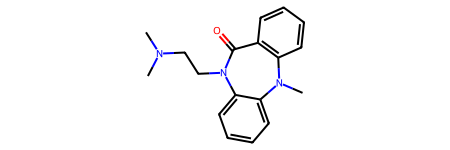

In [9]:
train_rdkit_mols = [MolFromSmiles(str(m)) for m in train_mols]
test_rdkit_mols = [MolFromSmiles(str(m)) for m in test_mols]
val_rdkit_mols = [MolFromSmiles(str(m)) for m in val_mols]
val_rdkit_mols[0]

#### 1.1 Генерация дескрипторов

In [10]:
def calc_fingerprints(mols):
    """ генерация молекулярных отпечатков по методу Моргана с радиусом 3 и длиной 2048
    """
    morgan_fpgenerator = fp.GetMorganGenerator(radius=3, fpSize=2048)
    return pd.DataFrame([morgan_fpgenerator.GetFingerprintAsNumPy(m) for m in mols])

PhisChemDescriptors = {"MR": Descriptors.MolMR,
                       "TPSA": Descriptors.TPSA}

# функция для генерации дескрипторов из молекул
def mol_dsc_calc(mols): 
    return pd.DataFrame({k: f(m) for k, f in PhisChemDescriptors.items()} 
                     for m in mols)

descriptors_names = PhisChemDescriptors.keys()

Сгенерируем дескрипторы и молекулярные отпечатки и сохраним их в отдельные датафреймы:

In [11]:
descriptors_datasets = defaultdict(dict)

descriptors_transformer = FunctionTransformer(mol_dsc_calc, validate=False)
morgan_transformer = FunctionTransformer(calc_fingerprints, validate=False)

train_rdkit_data = pd.DataFrame(train_rdkit_mols, columns=['molecules'])
test_rdkit_data = pd.DataFrame(test_rdkit_mols, columns=['molecules'])
val_rdkit_data = pd.DataFrame(val_rdkit_mols, columns=['molecules'])


datasets = {'train': train_rdkit_mols, 'test': test_rdkit_mols, 'val': val_rdkit_mols}

for dataset_name, data in datasets.items():
    data_df = pd.DataFrame(data, columns=['structure'])
    print(dataset_name)
    X = morgan_transformer.transform(data_df.structure)

    X_desc = descriptors_transformer.fit_transform(data_df.structure)
    descriptors_datasets[dataset_name] = pd.concat([data_df.drop(columns=['structure']), X, X_desc], axis=1)


train
test
val


In [12]:
num_cols_to_drop = [x for x in descriptors_datasets['train'].columns.to_list() if not isinstance(x, int)]
bool_cols_to_drop = [x for x in descriptors_datasets['train'].columns.to_list() if x not in ['TPSA', 'MR']]

In [13]:
separated_features_df = {}
for dataset_name, df in descriptors_datasets.items():
    num_cols_to_drop = [x for x in descriptors_datasets[f'{dataset_name}'].columns.to_list() if not isinstance(x, int)]
    bool_cols_to_drop = [x for x in descriptors_datasets[f'{dataset_name}'].columns.to_list() if x not in ['TPSA', 'MR']]
    separated_features_df[f'Xd_{dataset_name}'] = df.drop(columns=bool_cols_to_drop)
    separated_features_df[f'Xfp_{dataset_name}'] = df.drop(columns=num_cols_to_drop)

In [14]:
list(separated_features_df.keys())

['Xd_train', 'Xfp_train', 'Xd_test', 'Xfp_test', 'Xd_val', 'Xfp_val']

In [15]:
Xd_train, Xd_test, Xd_val, Xfp_train, Xfp_test, Xfp_val = \
separated_features_df['Xd_train'], separated_features_df['Xd_test'], separated_features_df['Xd_val'], \
separated_features_df['Xfp_train'], separated_features_df['Xfp_test'], separated_features_df['Xfp_val']

In [16]:
Xd_test

,MR,TPSA
0,110.5871,90.54
1,84.9130,148.57
2,103.7648,85.08
3,101.3264,158.82
4,106.4743,110.42
...,...,...
2625,136.9621,170.85
2626,147.7249,127.87
2627,150.5970,101.53
2628,152.5858,91.37


### 1.2 Нормализация численных значений

**Формула стандартизации (Z-score Normalization)**:

$$
Y_{\text{norm}} = \frac{Y - \mu}{\sigma}
$$


Где:


- $Y$ — исходные данные,
- $\mu$ — среднее значение \( Y \),
- $\sigma$ — стандартное отклонение \( Y \).

In [17]:
df_to_scale =  [Xd_train, Xd_test, Xd_val]
scaler = StandardScaler()
scaler.fit(Xd_train)
for n, df in enumerate(df_to_scale):
    df = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_to_scale[n] = np.array(df)

Xd_train, Xd_test, Xd_val = df_to_scale
Xd_train

array([[1.29921506, 1.81699789],
       [1.35325521, 1.43840238],
       [1.6401442 , 0.32418501],
       ...,
       [3.25135023, 0.58613677],
       [3.15265381, 0.99339656],
       [3.18880431, 2.32500836]])

Приведем датафреймы с отпечатками моргана в нужный формат:

In [18]:
Xfp_train, Xfp_test, Xfp_val = np.array(Xfp_train), np.array(Xfp_test), np.array(Xfp_val)

In [22]:
Y_train = np.array(train_data['LogP'])
# Генерируем данные LogP для тестовой и валидационной выборке, поскольку эти данные требуется предсказать
Y_test = np.array([0] * test_data.shape[0])
Y_val = np.array([0] * val_data.shape[0])

In [24]:
Xd_train.shape, Xd_test.shape

((9262, 2), (2630, 2))

In [25]:
Xfp_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

## 2. Обучение и валидация модели

#### Создание модели на основе нейронной сети в виде многослойного персептрона с одним скрытым слоем

Подготовим данные для обучения в нужном формате:

In [26]:
Xfp_train = torch.Tensor(Xfp_train)
Xfp_test = torch.Tensor(Xfp_test)
Xfp_val = torch.Tensor(Xfp_val)
Xd_train = torch.Tensor(Xd_train)
Xd_test = torch.Tensor(Xd_test)
Xd_val = torch.Tensor(Xd_val)

In [27]:
Y_train = torch.Tensor(Y_train).unsqueeze(-1)
Y_test = torch.Tensor(Y_test).unsqueeze(-1)
Y_val = torch.Tensor(Y_val).unsqueeze(-1)

Y_train.shape, Y_test.shape

(torch.Size([9262, 1]), torch.Size([2630, 1]))

Определим конфигурацию:

In [28]:
BATCH_SIZE = 50
EPOCHS = 50
HIDDEN_SIZE = 256

Создадим объект DataLoader - загрузчик данных, который делит входные данные на партии определенного размера - батчи  и подает их на обучение нейронной сети. Создадим загрузчики для каждой из выборок:

In [29]:
class LogPDataset(Dataset):
    def __init__(self, X, y, device):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = TensorDataset(Xfp_train, Xd_train, Y_train)
test_dataset = TensorDataset(Xfp_test, Xd_test, Y_test)
val_dataset = TensorDataset(Xfp_val, Xd_val, Y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Создадим класс LogPModel для определения архитектуры нейронной сети с одним скрытым слоем и двумя входными потоками для обработки отдельно физико-химических дескрипторов и молекулярных отпечатков:

In [30]:
class LogPModel(pyl.LightningModule):
    def __init__(self, fingerprint_size, numeric_features_size, hidden_size=HIDDEN_SIZE):
        super(LogPModel, self).__init__()
        self.test_predictions = []
        self.targets = []

        self.fingerprint_fc = nn.Sequential(
            nn.Linear(fingerprint_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU()
        )
        self.numeric_fc = nn.Sequential(
            nn.Linear(numeric_features_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU()
        )
        
        self.combined_fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.loss_fn = nn.MSELoss()

    def forward(self, fingerprint, numeric_features):
        fingerprint_out = self.fingerprint_fc(fingerprint)
        numeric_out = self.numeric_fc(numeric_features)
        
        combined = torch.cat([fingerprint_out, numeric_out], dim=1)
        
        return self.combined_fc(combined)

    def training_step(self, batch, batch_idx):
        fingerprint, numeric_features, y = batch
        y_pred = self(fingerprint, numeric_features)

        loss = self.loss_fn(y_pred, y)
        self.log('Train MSE', loss, on_step=False, on_epoch=True, prog_bar=True)

        r2 = r2_score(y.detach().cpu().numpy().reshape(-1), y_pred.detach().cpu().numpy().reshape(-1))
        self.log('Train R²', r2, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        fingerprint, numeric_features, y = batch
        y_pred = self(fingerprint, numeric_features)

        loss = self.loss_fn(y_pred, y)
        self.log('Validation MSE', loss, on_step=False, on_epoch=True, prog_bar=True)

        r2 = r2_score(y.detach().cpu().numpy().reshape(-1), y_pred.detach().cpu().numpy().reshape(-1))
        self.log('Validation R²', r2, on_step=False, on_epoch=True, prog_bar=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        fingerprint, numeric_features, y = batch
        y_pred = self(fingerprint, numeric_features)

        loss = self.loss_fn(y_pred, y)
        self.log('Test MSE', loss, on_step=False, on_epoch=True, prog_bar=True)

        self.test_predictions.extend(y_pred.cpu().numpy())
        self.targets.extend(y.cpu().numpy())
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

Создадим и обучим модель:

In [31]:
model = LogPModel(fingerprint_size=Xfp_train.shape[1], numeric_features_size=Xd_train.shape[1]).to(device)

# metrics_callback = MetricsCallback(val_loader, train_loader, device)

trainer = pyl.Trainer(max_epochs=EPOCHS, accelerator="auto")
trainer.fit(model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | fingerprint_fc | Sequential | 590 K  | train
1 | numeric_fc     | Sequential | 66.6 K | train
2 | combined_fc    | Sequential | 131 K  | train
3 | loss_fn        | MSELoss    | 0      | train
------------------------------------------------------
788 K     Trainable params
0         Non-trainable params
788 K     Total params
3.154     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 186/186 [00:02<00:00, 74.74it/s, v_num=1, Validation MSE=15.50, Validation R²=0.000, Train MSE=0.0137, Train R²=0.996]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 186/186 [00:02<00:00, 73.90it/s, v_num=1, Validation MSE=15.50, Validation R²=0.000, Train MSE=0.0137, Train R²=0.996]


Оценим модель на внешней контрольной выборке:

In [32]:
trainer.test(model, test_loader)

y_pred_test = model.test_predictions
y_true = model.targets
mse = mean_squared_error(y_true, y_pred_test)
q2 = r2_score(y_true, y_pred_test)
rmse = np.sqrt(mse)
print(f'test MSE: {mse:.4f}, test PRMSE: {rmse:.4f}, test Q²: {q2:.4f}')


Testing DataLoader 0: 100%|██████████| 2630/2630 [00:09<00:00, 265.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test MSE          │    15.227682113647461     │
└───────────────────────────┴───────────────────────────┘

test MSE: 15.2277, test PRMSE: 3.9023, test Q²: 0.0000


In [ ]:
# Откроем файл sample_submission и запишем в него предсказание
sample_submission = pd.read_csv("sample_submission.csv")
# Добавим в качестве предсказаний тестовые данные
sample_submission['LogP'] = [round(float(i), 5) for i in y_pred_test]

In [34]:
# Сохраняем прежсказание 
sample_submission.to_csv("prediction.csv", index=False)